In [41]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Requirement already up-to-date: nltk in /Users/Alexander/anaconda3/envs/dataweekends/lib/python3.6/site-packages (3.4)


[nltk_data] Downloading package punkt to /Users/Alexander/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [42]:
##### Your Code Here #####

In [43]:
df = pd.read_csv('job_listings.csv', index_col=['Unnamed: 0'])
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


## 2) Use NLTK to tokenize / clean the listings 

In [44]:
df['description'] = df['description'].apply(lambda x: re.sub('^b[\'|"]','',x))
df['description'] = df['description'].apply(lambda x: re.sub('.[\'|"]','',x))
df['description'] = df['description'].apply(lambda x: re.sub('<.*?>', '', x))

In [45]:
df['description'].head()

0    Job Requirements:\nConceptual understanding in...
1    Job Description\n\nAs a Data Scientist 1, you ...
2    As a Data Scientist you will be working on con...
3    $4,969 - $6,756 a monthContractUnder the gener...
4    Location: USA \xe2\x80\x93 multiple locations\...
Name: description, dtype: object

In [46]:
table = str.maketrans('','', string.punctuation)
stop_words = set(stopwords.words('english'))

def nltk_tokenize(input):
  
  # Tokenize by word
  tokens = word_tokenize(input)
  #print("Tokens:", tokens)
  # Make all words lowercase
  lowercase_tokens = [w.lower() for w in tokens]
  #print("Lowercase:", lowercase_tokens)
  # Strip punctuation from within words
  no_punctuation = [x.translate(table) for x in lowercase_tokens]
  #print("No Punctuation:", no_punctuation)
  # Remove words that aren't alphabetic
  alphabetic = [word for word in no_punctuation if word.isalpha()]
  #print("Alphabetic:", alphabetic)
  # Remove stopwords
  words = [w for w in alphabetic if not w in stop_words]
  #print("Cleaned Words:", words)
  #print("--------------------------------")
  # Append to list
  return words

In [47]:
df['description_tokenized'] = df['description'].apply(nltk_tokenize)
df['title_tokenized'] = df['title'].apply(nltk_tokenize)
df.head()

,description,title,description_tokenized,title_tokenized
0,Job Requirements:\nConceptual understanding in...,Data scientist,"[job, requirements, nconceptual, understanding...","[data, scientist]"
1,"Job Description\n\nAs a Data Scientist 1, you ...",Data Scientist I,"[job, descriptionnnas, data, scientist, help, ...","[data, scientist]"
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, working, consulting, side, b...","[data, scientist, entry, level]"
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[monthcontractunder, general, supervision, pro...","[data, scientist]"
4,Location: USA \xe2\x80\x93 multiple locations\...,Data Scientist,"[location, usa, multiple, years, analytics, ex...","[data, scientist]"


# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [48]:
##### Your Code Here #####
description_vector = []
for i in df['description_tokenized']:
    new_description = " ".join(i)
    description_vector.append(new_description)
    
df['description_vector'] = description_vector

In [49]:
title_vector = []
for i in df['title_tokenized']:
    new_title = " ".join(i)
    title_vector.append(new_title)

df['title_vector'] = title_vector

In [50]:
df.head()

,description,title,description_tokenized,title_tokenized,description_vector,title_vector
0,Job Requirements:\nConceptual understanding in...,Data scientist,"[job, requirements, nconceptual, understanding...","[data, scientist]",job requirements nconceptual understanding mac...,data scientist
1,"Job Description\n\nAs a Data Scientist 1, you ...",Data Scientist I,"[job, descriptionnnas, data, scientist, help, ...","[data, scientist]",job descriptionnnas data scientist help us bui...,data scientist
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, working, consulting, side, b...","[data, scientist, entry, level]",data scientist working consulting side busines...,data scientist entry level
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[monthcontractunder, general, supervision, pro...","[data, scientist]",monthcontractunder general supervision profess...,data scientist
4,Location: USA \xe2\x80\x93 multiple locations\...,Data Scientist,"[location, usa, multiple, years, analytics, ex...","[data, scientist]",location usa multiple years analytics experien...,data scientist


In [51]:
vectorizer = CountVectorizer()

bag_of_words = vectorizer.fit_transform(df['description_vector'])

print(bag_of_words.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [52]:
feature_names = vectorizer.get_feature_names()

In [53]:
import pandas as pd

description_vectorized = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
description_vectorized.head()

,aaai,aaeeo,ab,abernathy,abest,abig,abilities,abilitiesnability,abilitiesndevelops,abilitiesnexperience,...,zero,zeus,zf,zheng,zillow,zillows,zonesnability,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4) Visualize the most common word counts

In [58]:
##### Your Code Here #####
from nltk.probability import FreqDist

fdist = FreqDist(df['description_tokenized'][1])

fdist.most_common(20)

[('data', 4),
 ('us', 4),
 ('development', 4),
 ('help', 3),
 ('machine', 3),
 ('learning', 3),
 ('team', 3),
 ('design', 3),
 ('effectively', 3),
 ('technical', 3),
 ('experience', 3),
 ('pipelines', 2),
 ('microservices', 2),
 ('applications', 2),
 ('agile', 2),
 ('mobile', 2),
 ('members', 2),
 ('best', 2),
 ('collaborative', 2),
 ('new', 2)]

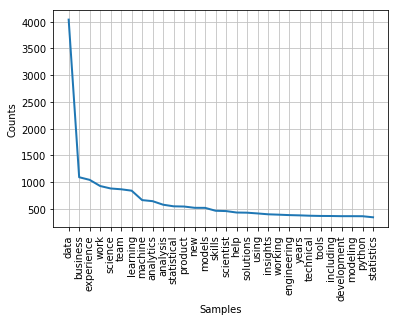

In [69]:
import matplotlib.pyplot as plt
fdist.plot(30, cumulative=False)
plt.show()

In [70]:
all_the_words = []
for row in df['description_tokenized']:
    for word in row:
        all_the_words.append(word)
        
print(len(all_the_words), all_the_words[:100])

128372 ['job', 'requirements', 'nconceptual', 'understanding', 'machine', 'learning', 'models', 'like', 'bayes', 'kmeans', 'svm', 'apriori', 'linear', 'logistic', 'regression', 'neural', 'random', 'forests', 'decision', 'trees', 'knn', 'along', 'handson', 'experience', 'least', 'themnintermediate', 'expert', 'level', 'coding', 'skills', 'pythonr', 'ability', 'write', 'functions', 'clean', 'efficient', 'data', 'manipulation', 'mandatory', 'role', 'nexposure', 'packages', 'like', 'numpy', 'scipy', 'pandas', 'matplotlib', 'etc', 'python', 'dplyr', 'tidyr', 'rnability', 'communicate', 'model', 'findings', 'technical', 'nontechnical', 'stake', 'holdersnhands', 'experience', 'sqlhive', 'similar', 'programming', 'languagenmust', 'show', 'past', 'work', 'via', 'github', 'kaggle', 'published', 'articlenmastes', 'degree', 'statisticsmathematicscomputer', 'science', 'quant', 'specific', 'fieldnapply', 'div', 'job', 'descriptionnnas', 'data', 'scientist', 'help', 'us', 'build', 'machine', 'learnin

In [71]:
fdist = FreqDist(all_the_words)

fdist.most_common(50)

[('data', 4037),
 ('business', 1094),
 ('experience', 1045),
 ('work', 930),
 ('science', 884),
 ('team', 869),
 ('learning', 843),
 ('machine', 667),
 ('analytics', 647),
 ('analysis', 581),
 ('statistical', 551),
 ('product', 547),
 ('new', 523),
 ('models', 522),
 ('skills', 468),
 ('scientist', 462),
 ('help', 435),
 ('solutions', 432),
 ('using', 418),
 ('insights', 402),
 ('working', 395),
 ('engineering', 387),
 ('years', 382),
 ('technical', 375),
 ('tools', 371),
 ('including', 370),
 ('development', 367),
 ('modeling', 367),
 ('python', 366),
 ('statistics', 346),
 ('opportunity', 342),
 ('analytical', 338),
 ('technology', 333),
 ('research', 332),
 ('teams', 331),
 ('amp', 329),
 ('degree', 327),
 ('across', 324),
 ('techniques', 314),
 ('ability', 313),
 ('people', 313),
 ('advanced', 312),
 ('knowledge', 310),
 ('company', 309),
 ('r', 308),
 ('us', 305),
 ('computer', 305),
 ('building', 302),
 ('support', 292),
 ('large', 291)]

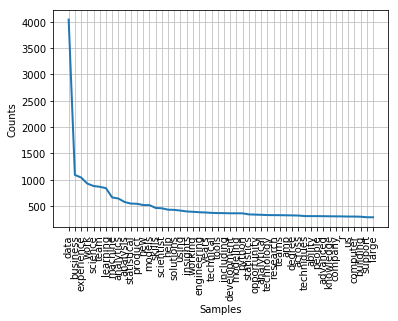

In [72]:
import matplotlib.pyplot as plt
fdist.plot(50, cumulative=False)

plt.show()

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [73]:
##### Your Code Here #####
df.head()

,description,title,description_tokenized,title_tokenized,description_vector,title_vector
0,Job Requirements:\nConceptual understanding in...,Data scientist,"[job, requirements, nconceptual, understanding...","[data, scientist]",job requirements nconceptual understanding mac...,data scientist
1,"Job Description\n\nAs a Data Scientist 1, you ...",Data Scientist I,"[job, descriptionnnas, data, scientist, help, ...","[data, scientist]",job descriptionnnas data scientist help us bui...,data scientist
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, working, consulting, side, b...","[data, scientist, entry, level]",data scientist working consulting side busines...,data scientist entry level
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[monthcontractunder, general, supervision, pro...","[data, scientist]",monthcontractunder general supervision profess...,data scientist
4,Location: USA \xe2\x80\x93 multiple locations\...,Data Scientist,"[location, usa, multiple, years, analytics, ex...","[data, scientist]",location usa multiple years analytics experien...,data scientist


In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=20)
feature_matrix = tfidf.fit_transform(df['description_vector'])
print(feature_matrix.toarray())

feature_names = tfidf.get_feature_names()

df = pd.DataFrame(feature_matrix.toarray(), columns=feature_names)
df.head()

[[0.         0.         0.         ... 0.         0.         0.29171435]
 [0.         0.         0.1088033  ... 0.31783098 0.         0.21036079]
 [0.         0.         0.53590573 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.17715795 ... 0.17250176 0.         0.        ]
 [0.0720661  0.         0.06429886 ... 0.18782674 0.07870755 0.1243157 ]
 [0.18347085 0.20361328 0.16369647 ... 0.07969704 0.20037911 0.47473722]]


,analysis,analytics,business,data,experience,help,insights,learning,machine,models,new,product,science,scientist,skills,solutions,statistical,team,using,work
0,0.0,0.000000,0.000000,0.235242,0.543085,0.000000,0.0,0.315354,0.337359,0.373342,0.000000,0.000000,0.295253,0.000000,0.353278,0.0,0.000000,0.000000,0.0,0.291714
1,0.0,0.000000,0.108803,0.339275,0.293722,0.401686,0.0,0.341112,0.364914,0.134612,0.260121,0.292333,0.212913,0.118611,0.000000,0.0,0.000000,0.317831,0.0,0.210361
2,0.0,0.000000,0.535906,0.417771,0.000000,0.000000,0.0,0.186681,0.199707,0.442017,0.000000,0.000000,0.174782,0.389476,0.209131,0.0,0.205389,0.000000,0.0,0.000000
3,0.0,0.000000,0.000000,0.388195,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.297628,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.727318,0.0,0.481385
4,0.0,0.487551,0.391970,0.611130,0.000000,0.000000,0.0,0.000000,0.000000,0.484947,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.